In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet


In [2]:
train=pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
test=pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
submission=pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')
class_map=pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')

In [3]:
import keras
# create class which allow to data augmentation for multioutput. 
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

Using TensorFlow backend.


In [4]:
from PIL import Image , ImageOps
from PIL import ImageFilter
def preprocessing (img):
    """ """
    image= Image.fromarray(img).convert('L')
    image=image.filter(ImageFilter.GaussianBlur(radius=2))
    image= ImageOps.autocontrast(image)
    return image

In [5]:
from tqdm.auto import tqdm
import cv2
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            img=preprocessing(image)
            img=np.array(img)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = img[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

# CNN architecture 

In [6]:
from keras.layers import Dense,Dropout,Input,MaxPooling2D, BatchNormalization,Conv2D,Flatten
from keras.models import Model
Inputs=Input(shape=(64,64,1))
model=Conv2D(64,(3,3),padding='same',input_shape=(64,64,1),activation='relu')(Inputs)
model=Conv2D(64,(3,3),padding='same',activation='relu')(model)
model=MaxPooling2D((2,2),strides=(2,2))(model)
model=BatchNormalization(momentum=0.15)(model)
model=Conv2D(128,(3,3),padding='same',activation='relu')(model)
model=Conv2D(128,(3,3),padding='same',activation='relu')(model)
model=MaxPooling2D((2,2),strides=(2,2))(model)
model=BatchNormalization(momentum=0.15)(model)
model=Conv2D(256,(3,3),padding='same',activation='relu')(model)
model=Conv2D(256,(3,3),padding='same',activation='relu')(model)
model=Conv2D(256,(3,3),padding='same',activation='relu')(model)
model=MaxPooling2D((2,2),strides=(2,2))(model)
model=BatchNormalization(momentum=0.15)(model)
model=Conv2D(512,(3,3),padding='same',activation='relu')(model)
model=Conv2D(512,(3,3),padding='same',activation='relu')(model)
model=Conv2D(512,(3,3),padding='same',activation='relu')(model)
model=MaxPooling2D((2,2),strides=(2,2))(model)
model=BatchNormalization(momentum=0.15)(model)
model=Conv2D(512,(3,3),padding='same',activation='relu')(model)
model=Conv2D(512,(3,3),padding='same',activation='relu')(model)
model=Conv2D(512,(3,3),padding='same',activation='relu')(model)
model=MaxPooling2D((2,2),strides=(2,2))(model)
model=BatchNormalization(momentum=0.15)(model)
model=Flatten()(model)
model=Dense(1024,activation='relu')(model)
dense=Dense(512,activation='relu')(model)
consonant=Dense(7,activation='softmax')(dense)
grapheme=Dense(168,activation='softmax')(dense)
vowel=Dense(11,activation='softmax')(dense)
model=Model(inputs=Inputs,outputs=[consonant,grapheme,vowel])

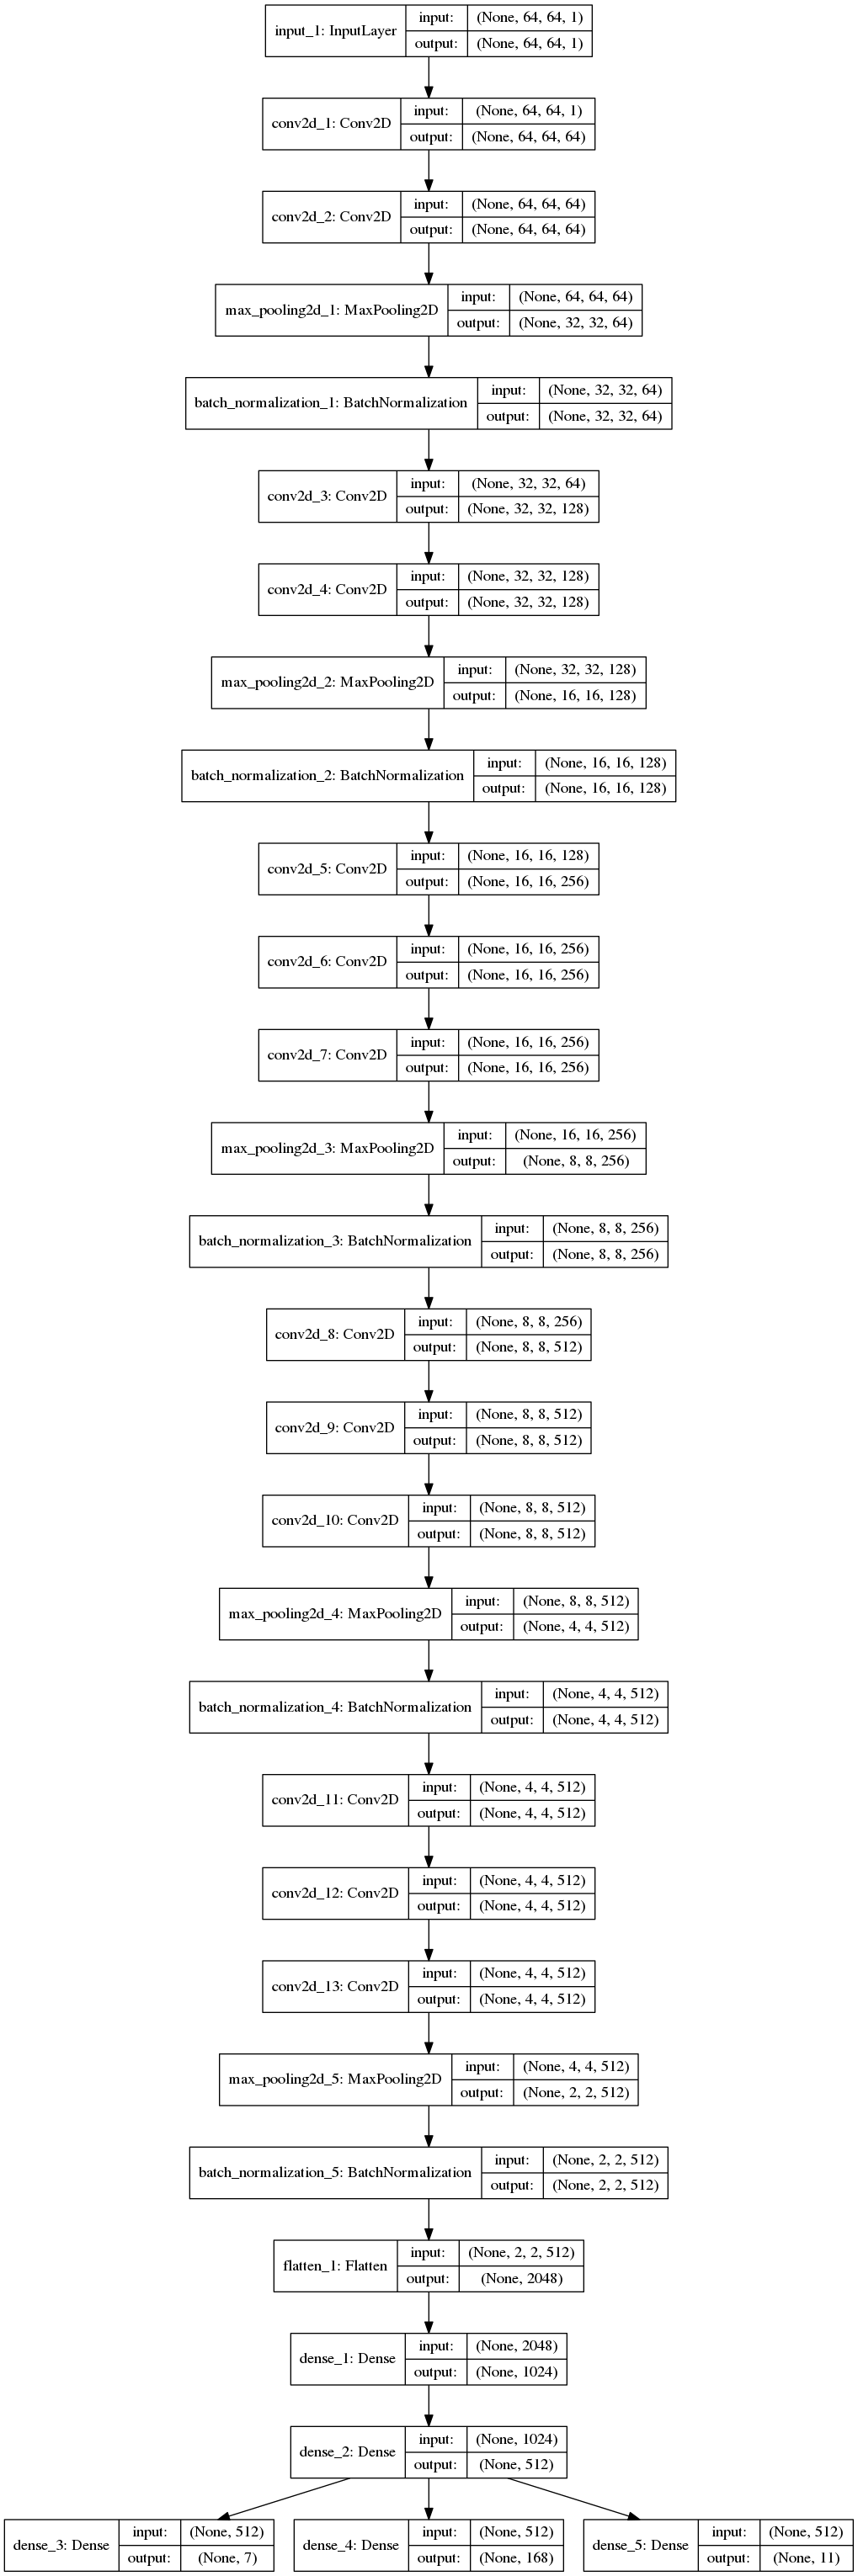

In [7]:
from keras.utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True)

In [8]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
from keras.callbacks import ReduceLROnPlateau
#Reducing learning rate when accuracy has stopped improving.
#We will use a callback wich will control the accuracy and reduce learning rate by 40% when the quantity
#controlled had not enhanced after 4 epochs 
lr_consonant=ReduceLROnPlateau(monitor='dense_3_accuracy',factor=0.4,patience=4,min_lr=0.00001)
lr_grapheme=ReduceLROnPlateau(monitor='dense_4_accuracy',factor=0.4,patience=4,min_lr=0.00001)
lr_vowel=ReduceLROnPlateau(monitor='dense_5_accuracy',factor=0.4,patience=4,min_lr=0.00001)

In [10]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
for i in range(4):
    df=pd.merge(pd.read_parquet('/kaggle/input/bengaliai-cv19/train_image_data_{}.parquet'.format(i)),train,\
                on='image_id',how='left').drop(['image_id','grapheme'],axis=1)
   
    X=df.drop(['grapheme_root','vowel_diacritic','consonant_diacritic'],axis=1)
    X=resize(X)/255
                                                                                                   
    X=X.to_numpy().reshape(-1,64,64,1)
    Y_consonant=pd.get_dummies(df['consonant_diacritic']).to_numpy()
    Y_grapheme=pd.get_dummies(df['grapheme_root']).to_numpy()
    Y_vowel=pd.get_dummies(df['vowel_diacritic']).to_numpy()
    del(df)
    # Divide the data into training and test data
    xtr,xts,ytr_consonant,yts_consonant,ytr_grapheme,yts_grapheme,ytr_vowel,yts_vowel=train_test_split(X,\
                                                            Y_consonant,Y_grapheme,Y_vowel,test_size=0.1)
    
    del(X)
    del(Y_consonant)
    del(Y_grapheme)
    del(Y_vowel)
    #data augmentation .
    datagen=MultiOutputDataGenerator(rotation_range=10 # rotate the image\
                                    ,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.15)
    datagen.fit(xtr)
    fichier=[]
    #train the model.
    md=model.fit_generator(datagen.flow(xtr,{'dense_3':ytr_consonant,'dense_4':ytr_grapheme,'dense_5':\
                                             ytr_vowel},batch_size=256),steps_per_epoch=len(xtr)/256,\
                          epochs=40,validation_data=(xts,[yts_consonant,yts_grapheme,yts_vowel]),\
                          callbacks=[lr_consonant,lr_grapheme,lr_vowel])
    fichier.append(md)
    # reduce memory
    del(xtr)
    del(xts)
    del(ytr_consonant)
    del(yts_consonant)
    del(ytr_grapheme)
    del(yts_grapheme)
    del(ytr_vowel)
    del(yts_vowel)


Epoch 1/40
177/176 [==============================] - 45s 254ms/step - loss: 7.5610 - dense_3_loss: 1.1305 - dense_4_loss: 4.6720 - dense_5_loss: 1.7584 - dense_3_accuracy: 0.6283 - dense_4_accuracy: 0.0333 - dense_5_accuracy: 0.3674 - val_loss: 6.6120 - val_dense_3_loss: 1.0440 - val_dense_4_loss: 4.4835 - val_dense_5_loss: 1.0840 - val_dense_3_accuracy: 0.6347 - val_dense_4_accuracy: 0.0456 - val_dense_5_accuracy: 0.6102
Epoch 2/40
177/176 [==============================] - 34s 194ms/step - loss: 5.8089 - dense_3_loss: 0.7975 - dense_4_loss: 4.0711 - dense_5_loss: 0.9403 - dense_3_accuracy: 0.7149 - dense_4_accuracy: 0.0776 - dense_5_accuracy: 0.6733 - val_loss: 5.0933 - val_dense_3_loss: 0.5214 - val_dense_4_loss: 3.7043 - val_dense_5_loss: 0.8709 - val_dense_3_accuracy: 0.8116 - val_dense_4_accuracy: 0.1131 - val_dense_5_accuracy: 0.6973
Epoch 3/40
177/176 [==============================] - 34s 194ms/step - loss: 4.0414 - dense_3_loss: 0.4890 - dense_4_loss: 2.8931 - dense_5_loss:

177/176 [==============================] - 34s 191ms/step - loss: 0.2538 - dense_3_loss: 0.0485 - dense_4_loss: 0.1289 - dense_5_loss: 0.0763 - dense_3_accuracy: 0.9852 - dense_4_accuracy: 0.9599 - dense_5_accuracy: 0.9756 - val_loss: 0.3444 - val_dense_3_loss: 0.0547 - val_dense_4_loss: 0.2240 - val_dense_5_loss: 0.0650 - val_dense_3_accuracy: 0.9865 - val_dense_4_accuracy: 0.9448 - val_dense_5_accuracy: 0.9851
Epoch 10/40
177/176 [==============================] - 35s 198ms/step - loss: 0.2343 - dense_3_loss: 0.0446 - dense_4_loss: 0.1165 - dense_5_loss: 0.0732 - dense_3_accuracy: 0.9866 - dense_4_accuracy: 0.9639 - dense_5_accuracy: 0.9768 - val_loss: 0.3498 - val_dense_3_loss: 0.0579 - val_dense_4_loss: 0.2227 - val_dense_5_loss: 0.0687 - val_dense_3_accuracy: 0.9861 - val_dense_4_accuracy: 0.9458 - val_dense_5_accuracy: 0.9851
Epoch 11/40
177/176 [==============================] - 34s 190ms/step - loss: 0.2212 - dense_3_loss: 0.0413 - dense_4_loss: 0.1100 - dense_5_loss: 0.0699 - 

In [11]:
ant=[]
for i in range(4):
    ts=pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i))
    ts=ts.drop(['image_id'],axis=1)
    ts=resize(ts,need_progress_bar=True)
    tss=ts.to_numpy()/255
    tss=tss.reshape(-1,64,64,1)
    prediction=model.predict(tss)
    l=len(ts)
    del(ts)
    m=0
    del(tss)
    for j in range(l):
        ant.append(np.argmax(prediction[0][m]))
        ant.append(np.argmax(prediction[1][m]))
        ant.append(np.argmax(prediction[2][m]))
        m+=1

In [12]:
submission['target']=ant

In [13]:
submission.to_csv('submission.csv',index=False)

In [14]:
submission

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0
